with 300K combined model and 1M combined model

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:

from sklearn.datasets import load_svmlight_file
from sklearn.externals import joblib
import argparse
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report

In [5]:
result = pd.read_csv('/Users/qingpeng/Dropbox/Genelearn/VicaData/all_2k_prediction.out.label.prediction_combined',sep=' ',header=None,names=['name','length','probability','prediction','vfam','pfam','diamond','label',
                                                                                       'score_euk_non_euk','pred_euk_non_euk','score_non_euk_virus','pred_non_euk_virus',
                                                                                      'score_virus_non_virus','pred_virus_non_virus'])

### Formular to calcuate hybrid probability score from score from old model and euk/non-euk model

In [6]:
result["hybrid_probability"] = (result["score_euk_non_euk"] * result["probability"])**0.5

In [7]:
result["hybrid_prediction"] = (result.hybrid_probability >0.5)

In [8]:
result.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,score_non_euk_virus,pred_non_euk_virus,score_virus_non_virus,pred_virus_non_virus,hybrid_probability,hybrid_prediction
0,NODE_1_length_91451_cov_163.114_g0_i0,91451,0.000375,0.0,0.0,0.0,0.0,0.0,0.000025,0.0,0.996004,1.0,0.001954,0.0,0.000097,False
1,NODE_2_length_74096_cov_303.895_g1_i0,74096,0.000088,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,0.995278,1.0,0.000529,0.0,0.000032,False
2,NODE_3_length_66420_cov_268.59_g1_i1,66420,0.000041,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,0.996629,1.0,0.000761,0.0,0.000019,False
3,NODE_4_length_61338_cov_317.585_g2_i0,61338,0.000056,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.991967,1.0,0.000477,0.0,0.000021,False
4,NODE_5_length_59036_cov_197.701_g0_i1,59036,0.000040,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.990354,1.0,0.000617,0.0,0.000018,False


In [9]:
### Using MEGAN annotation to check model performance 


from ete2 import NCBITaxa
ncbi = NCBITaxa()
def get_top_label(tax_id):
    lineage = ncbi.get_lineage(tax_id)
    for i in lineage:
        if i == 2759:
            return "Eukaryota"
        elif i == 10239:
            return "Virus"
        elif i == 2157:
            return "Archaea"
        elif i == 2:
            return "Bacteria"
        elif i == 12884:
            return "Viroids"
        elif i == 28384:
            return "other"
        elif i == 12908:
            return "unclassified"
    else:
        return "N/A"

def get_ranks(tax_id):
    ranks = ncbi.get_rank([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id
    
def get_name(tax_id):
    ranks = ncbi.get_taxid_translator([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id

# get MEGAN annotation results

megan_annot = pd.read_csv('./Micromonas/all_2k_contigs.fa.diamond-ex-all_tax_ID.txt',sep='\t',header=None,names=['name','tax_id'])

megan_annot['rank'] = megan_annot['tax_id'].apply(get_ranks)
megan_annot['tax_name']= megan_annot['tax_id'].apply(get_name)
megan_annot['top_label']= megan_annot['tax_id'].apply(get_top_label)


In [10]:
ranks = ncbi.get_lineage(186616)

In [11]:
ranks

[1, 10239, 186616]

In [12]:
megan_annot.head()

,name,tax_id,rank,tax_name,top_label
0,NODE_646_length_5889_cov_28.079_g448_i0,1,no rank,root,N/A
1,NODE_667_length_5857_cov_28.2491_g448_i1,1,no rank,root,N/A
2,NODE_671_length_5843_cov_18.2623_g465_i0,1,no rank,root,N/A
3,NODE_806_length_5513_cov_46.199_g556_i0,1,no rank,root,N/A
4,NODE_807_length_5513_cov_37.6629_g556_i1,1,no rank,root,N/A


In [13]:
new_table = pd.merge(result,megan_annot, on=['name'])

In [48]:
prediction_300k_full = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/all_2k_contigs.fa.prediction.300k_full')

In [49]:
prediction_3M_train = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/all_2k_contigs.fa.prediction.3M_train')

In [50]:
prediction_1M_combined = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/all_2k_contigs.fa.prediction.1M_full_run2')

In [51]:
prediction_300k_full.rename(index=str,columns={"ID": "name", "Prob_class_1":"Prob_class_1_300k_full"},inplace=True)

In [52]:
prediction_3M_train.rename(index=str,columns={"ID": "name", "Prob_class_1":"Prob_class_1_3M_train"},inplace=True)

In [53]:
prediction_1M_combined.rename(index=str,columns={"ID": "name", "Prob_class_1":"Prob_class_1_1M_combined"},inplace=True)

In [54]:
new_table_merge1 = pd.merge(new_table,prediction_300k_full, how='left',on=['name'])

In [55]:
new_table_merge2 = pd.merge(new_table_merge1,prediction_3M_train, how='left',on=['name'])

In [56]:
new_table_merge3 = pd.merge(new_table_merge2,prediction_1M_combined, how='left',on=['name'])

### 7041 contigs as ground-truth virus-related, with hits to virus-related domains, or annotated as virus by MEGAN based on BlastX/Diamond alignment

In [23]:
len(new_table[new_table.label==1.0])

7041

### 208302 contigs with length >=2k, in TARA


In [21]:
len(new_table_300k_combined)

208302

In [58]:
new_table_merge3["non_euk_label"] = (new_table_merge3.top_label!='Eukaryota')

In [59]:
new_table_merge3["micromonas_label"] = (new_table_merge3.tax_name=='Micromonas') |(new_table_merge3.tax_name=='Micromonas pusilla CCMP1545')|(
        new_table_merge3.tax_name=='Micromonas commoda')


#### "no rank" does not equal "no annotation"

In [60]:
def convert_top_label(top_label):
    if top_label == 'N/A':
        return 'no annotation'
    else:
        return 'with annotation'

In [61]:
new_table_merge3['annotation_label'] = new_table_merge3['top_label'].map(convert_top_label)

### Split the TARA contigs into 3 categories

- "Virus" has virus-related domain hits or annotated as "virus" by MEGAN
- "Non-virus" , no virus-related domain hits, annotated as some non-virus taxonomical group by MEGAN 
- "Unknown",  no virus-related domain hits, not annotated into any taxonomical group by MEGAN, top_label as "N/A"

#### subsample "non-virus" and "unknown" to have same number of "Virus" contigs - 6913

In [62]:
# "non-virus" data frame... non-virus and with annotation by MEGAN
df_nonvirus = new_table_merge3[new_table_merge3.label==0.0][new_table_merge3['annotation_label']== 'with annotation']
df_nonvirus_subsample = df_nonvirus.sample(n=7041, replace=False)
#df_nonvirus_subsample.to_csv('df_nonvirus_subsample.csv')

# "Unknown" data frame... and without annotation by MEGAN

df_unknown = new_table_merge3[new_table_merge3.label==0.0][new_table_merge3['annotation_label']== 'no annotation']
df_unknown_subsample = df_unknown.sample(n=7041, replace=False)
#df_unknown_subsample.to_csv('df_unknown_subsample.csv')

### "Virus" contigs...  has pfam hits or annotated as "virus" by MEGAN
df_virus = new_table_merge3[new_table_merge3.label==1.0]
#df_virus.to_csv('df_virus.csv')



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [63]:
def get_category(df):
    if df.label == 0.0:
        if df.annotation_label == 'with annotation':
            return 'nonvirus'
        else:
            return 'unknown'
    else:
        return 'virus'

In [64]:
new_table_merge3['category'] = new_table_merge3.apply(get_category, axis=1)

In [65]:
new_table_merge3.groupby('category').describe()


Class                                               Class_id  \
             count      mean       std  min  25%  50%  75%  max     count   
category                                                                    
nonvirus  190956.0  1.820880  0.687794  0.0  1.0  2.0  2.0  3.0  190956.0   
unknown    10202.0  1.659675  0.741345  1.0  1.0  1.0  2.0  3.0   10202.0   
virus       7041.0  1.068456  0.302688  1.0  1.0  1.0  1.0  3.0    7041.0   

                   ...      tax_id                 vfam                      \
              mean ...         75%        max     count      mean       std   
category           ...                                                        
nonvirus  1.820880 ...    296587.0  1904754.0  191023.0  0.000000  0.000000   
unknown   1.659675 ...    131567.0   171193.0   10238.0  0.000000  0.000000   
virus     1.068456 ...   1407671.0  1880590.0    7041.0  0.014771  0.120642   

                                   
          min  25%  50%  75%  max  
category                           
nonvirus  0.0  0.0  0.0  0.0  0.0  
unknown   0.0  0.0  0.0  0.0  0.0  
virus     0.0  0.0  0.0  0.0  1.0  

[3 rows x 264 columns]

#### subsample "non-euk" to have same number of "euk" contigs, for evaluating euk/non-euk model

In [66]:
# "non-euk" data frame... non-virus and with annotation by MEGAN
df_euk = new_table_merge3[new_table_merge3.non_euk_label==False][new_table_merge3['annotation_label']== 'with annotation']

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [67]:
len(df_euk)

40920

In [68]:
df_euk.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,Class,Class_id,Prob_class_0,Prob_class_1_1M_combined,Prob_class_2,Prob_class_3,non_euk_label,micromonas_label,annotation_label,category
268,NODE_269_length_13662_cov_37.4019_g165_i0,13662,1.000000,1.0,0.0,0.0,0.0,0.0,0.618436,1.0,...,1.0,1.0,4.383380e-04,9.175010e-01,0.007321,7.474000e-02,False,False,with annotation,nonvirus
326,NODE_327_length_11643_cov_43.6716_g200_i0,11643,0.000126,0.0,0.0,0.0,0.0,0.0,0.011231,0.0,...,2.0,2.0,5.389890e-04,2.665240e-04,0.975469,2.372530e-02,False,False,with annotation,nonvirus
348,NODE_349_length_11091_cov_73.7458_g215_i0,11091,0.000057,0.0,0.0,0.0,0.0,0.0,0.045895,0.0,...,2.0,2.0,7.116190e-04,4.866350e-04,0.905495,9.330670e-02,False,False,with annotation,nonvirus
517,NODE_518_length_8292_cov_38.7037_g335_i0,8292,0.002875,0.0,0.0,0.0,0.0,0.0,0.000803,0.0,...,2.0,2.0,7.540480e-04,2.957290e-03,0.978564,1.772480e-02,False,False,with annotation,nonvirus
522,NODE_523_length_8242_cov_224.933_g340_i0,8242,0.000006,0.0,0.0,0.0,0.0,0.0,0.022461,0.0,...,2.0,2.0,8.543460e-07,8.616370e-07,0.999998,3.514320e-08,False,False,with annotation,nonvirus


In [69]:
df_noneuk = new_table_merge3[new_table_merge3.non_euk_label==True][new_table_merge3['annotation_label']== 'with annotation']

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [70]:
len(df_noneuk)

156823

In [71]:
df_noneuk_subsample = df_noneuk.sample(n=40920, replace=False)

In [72]:
df_virus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,Prob_class_3_y,Class,Class_id,Prob_class_0,Prob_class_1_1M_combined,Prob_class_2,Prob_class_3,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.507400,2.0,2.0,0.003184,0.006785,0.545710,0.444321,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.149424,1.0,1.0,0.006002,0.861805,0.106836,0.025357,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.353349,2.0,2.0,0.020173,0.244392,0.609811,0.125624,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.056174,1.0,1.0,0.002464,0.918208,0.064930,0.014399,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.782471,1.0,1.0,0.002768,0.844905,0.022769,0.129558,True,False,with annotation


In [73]:
df_micromonus = new_table_merge3[new_table_merge3.micromonas_label==True]

In [74]:
len(df_micromonus)

9586

In [75]:
df_micromonus.to_csv("Micromonas_table.csv")

In [76]:
df_nonvirus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,Prob_class_3_y,Class,Class_id,Prob_class_0,Prob_class_1_1M_combined,Prob_class_2,Prob_class_3,non_euk_label,micromonas_label,annotation_label
0,NODE_1_length_91451_cov_163.114_g0_i0,91451,0.000375,0.0,0.0,0.0,0.0,0.0,0.000025,0.0,...,7.056080e-13,2.0,2.0,1.060660e-07,0.000113,0.999887,4.107130e-15,True,False,with annotation
1,NODE_2_length_74096_cov_303.895_g1_i0,74096,0.000088,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,...,1.381120e-13,2.0,2.0,1.384510e-08,0.000006,0.999994,6.699520e-16,True,False,with annotation
2,NODE_3_length_66420_cov_268.59_g1_i1,66420,0.000041,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,...,8.154490e-11,2.0,2.0,1.072090e-07,0.000007,0.999993,1.115700e-12,True,False,with annotation
3,NODE_4_length_61338_cov_317.585_g2_i0,61338,0.000056,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,...,3.196500e-13,2.0,2.0,2.839570e-08,0.000024,0.999976,1.157360e-15,True,False,with annotation
4,NODE_5_length_59036_cov_197.701_g0_i1,59036,0.000040,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,...,1.307740e-11,2.0,2.0,5.799570e-08,0.000002,0.999998,2.616740e-13,True,False,with annotation


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x135b81590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1380bbad0>]], dtype=object)

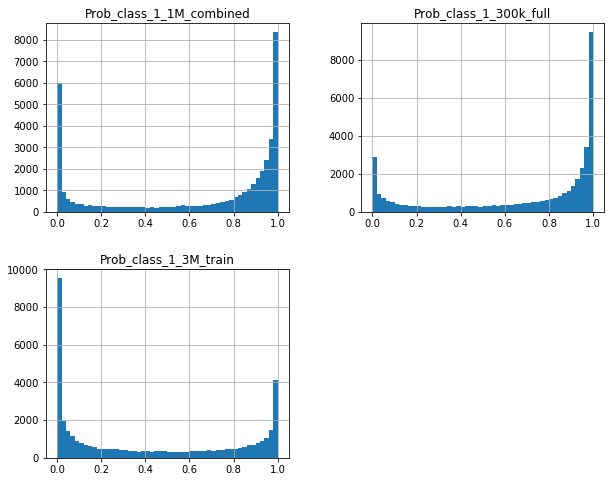

In [81]:
df_euk.hist(figsize=(10,8),column=['Prob_class_1_300k_full', 'Prob_class_1_3M_train', 'Prob_class_1_1M_combined'],bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13880b990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x139f43150>]], dtype=object)

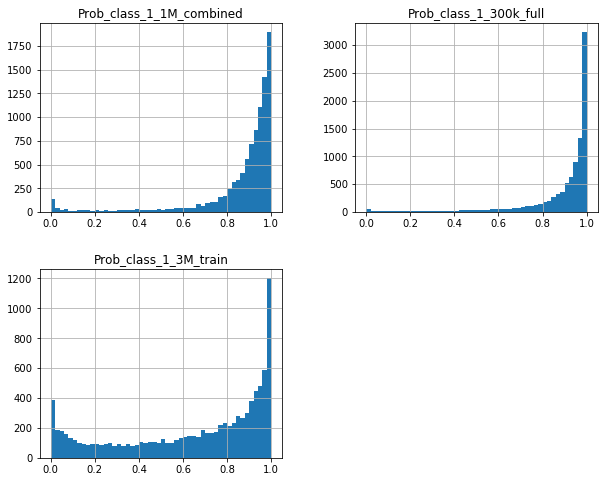

In [82]:
df_micromonus.hist(figsize=(10,8),column=['Prob_class_1_300k_full', 'Prob_class_1_3M_train', 'Prob_class_1_1M_combined'],bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a034510>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13a51a050>]], dtype=object)

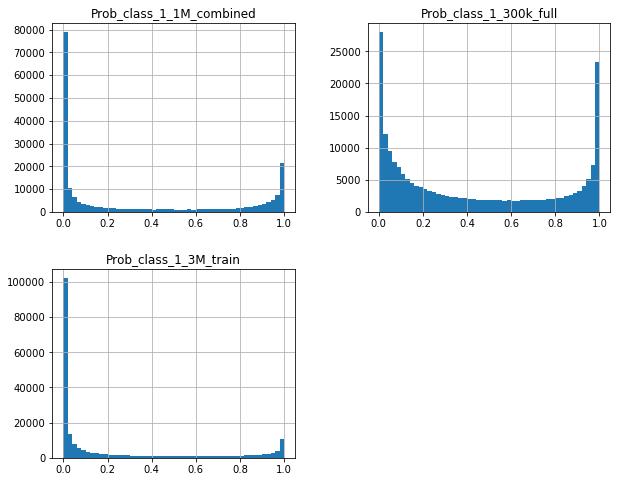

In [83]:
new_table_merge3.hist(figsize=(10,8),column=['Prob_class_1_300k_full', 'Prob_class_1_3M_train', 'Prob_class_1_1M_combined'],bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a8062d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13ace65d0>]], dtype=object)

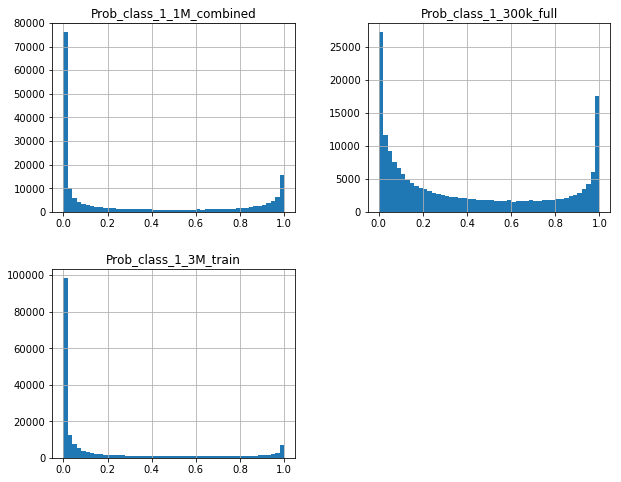

In [84]:
df_nonvirus.hist(figsize=(10,8),column=['Prob_class_1_300k_full', 'Prob_class_1_3M_train', 'Prob_class_1_1M_combined'],bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13ae062d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13b2e1290>]], dtype=object)

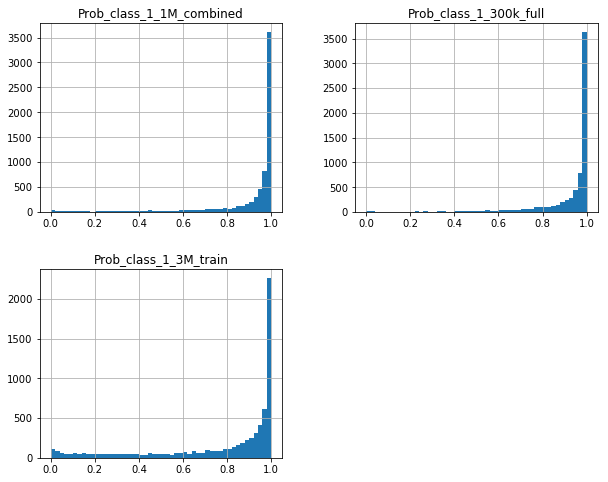

In [85]:
df_virus.hist(figsize=(10,8),column=['Prob_class_1_300k_full', 'Prob_class_1_3M_train', 'Prob_class_1_1M_combined'],bins=50)

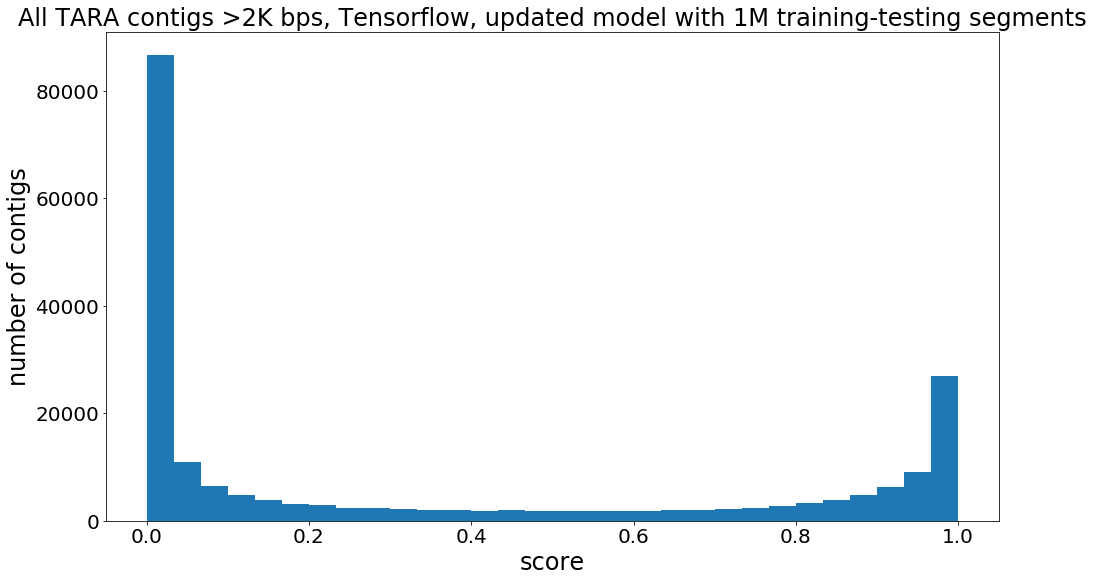

In [41]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [new_table_1M_combined[new_table_1M_combined.Prob_class_1>0].Prob_class_1]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'
                                                  ],
         )
ax0.set_title('All TARA contigs >2K bps, Tensorflow, updated model with 1M training-testing segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)



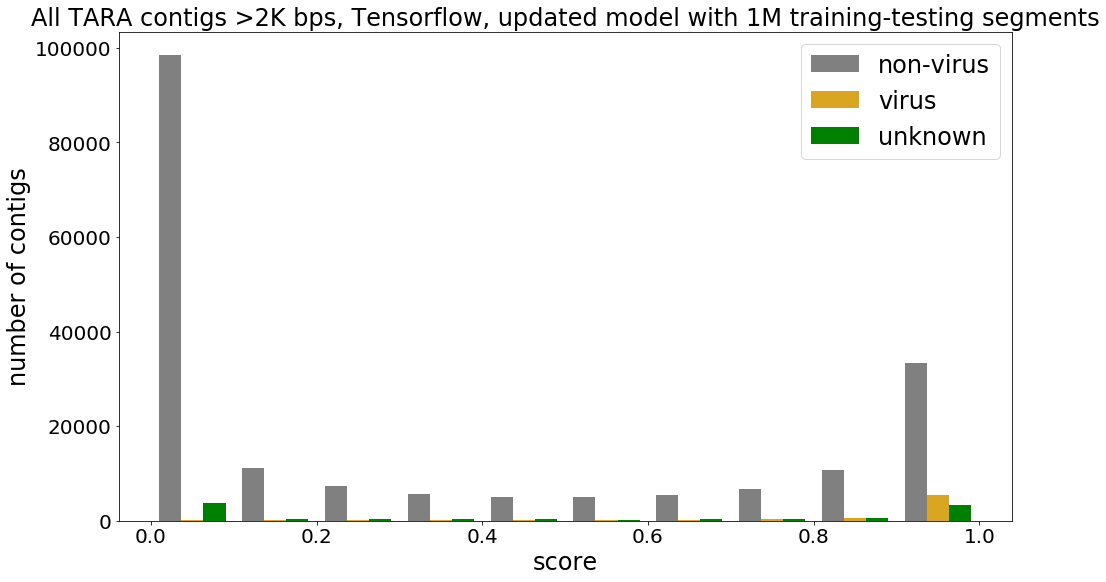

In [97]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus.Prob_class_1_1M_combined,df_virus.Prob_class_1_1M_combined,
           df_unknown.Prob_class_1_1M_combined]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus',
                                                  'virus',
                                                  'unknown'],
         color=['grey', 'goldenrod', 'green'])
ax0.set_title('All TARA contigs >2K bps, Tensorflow, updated model with 1M training-testing segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

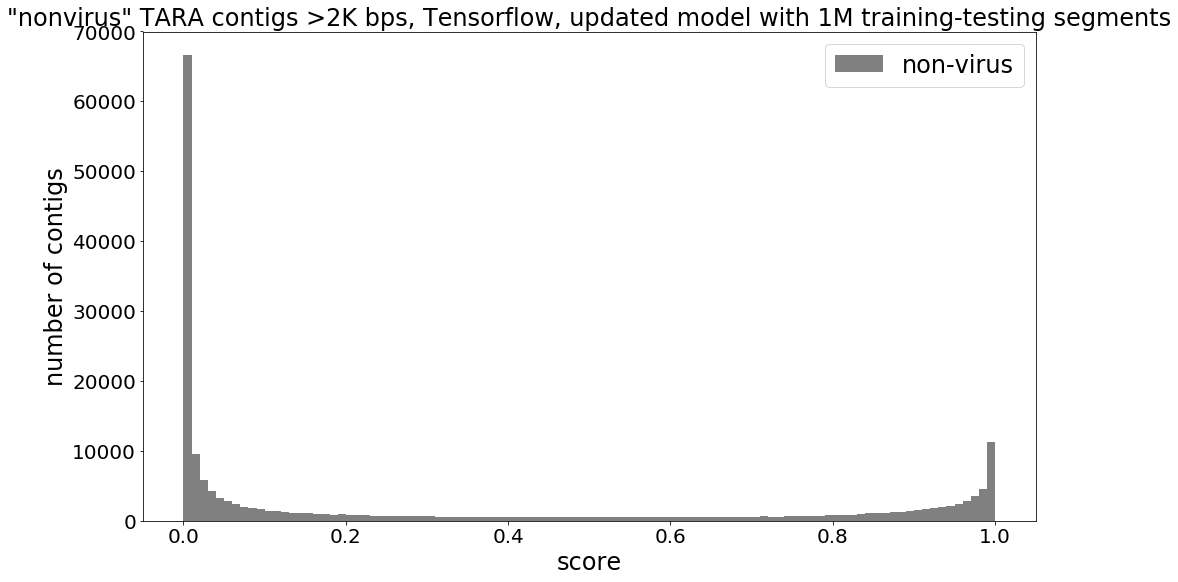

In [43]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 100
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus[df_nonvirus.Prob_class_1>0].Prob_class_1]
ax0.hist(x_multi, n_bins, histtype='bar',  label=[
                                                  'non-virus'],
         color=['grey'])
ax0.set_title('"nonvirus" TARA contigs >2K bps, Tensorflow, updated model with 1M training-testing segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

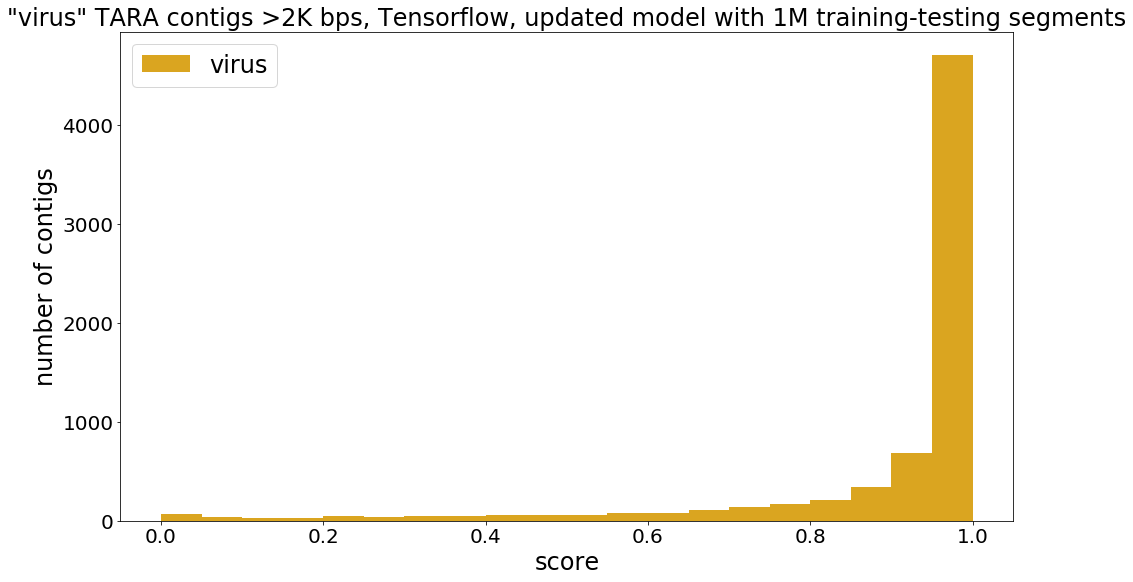

In [44]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 20
#colors = ['red', 'blue', 'grey']
x_multi = [df_virus[df_virus.Prob_class_1>0].Prob_class_1]
ax0.hist(x_multi, n_bins, histtype='bar',  label=[
                                                  'virus'],
         color=['goldenrod'])
ax0.set_title('"virus" TARA contigs >2K bps, Tensorflow, updated model with 1M training-testing segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

### Check the Precision-recall curve of old model and hybrid model

#### Check the distribution of probability of same number of "virus", "non-virus", 'unknown" contigs

#### Balanced data, same number of "virus" and "non-virus" contigs

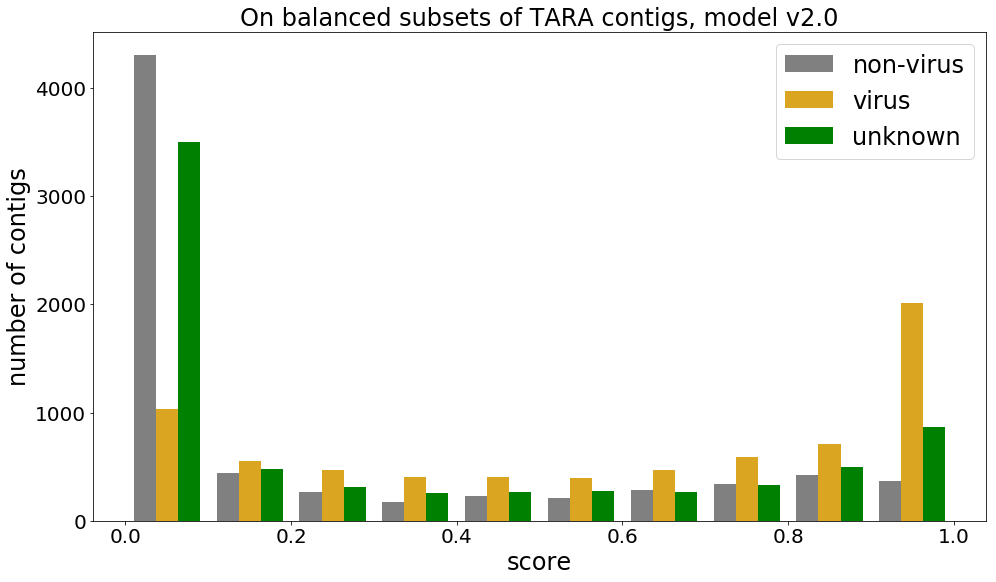

In [163]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.hybrid_probability,df_virus.hybrid_probability, df_unknown_subsample.hybrid_probability ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus','virus','unknown'],color=['grey', 'goldenrod', 'green'])
ax0.set_title('On balanced subsets of TARA contigs, model v2.0',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

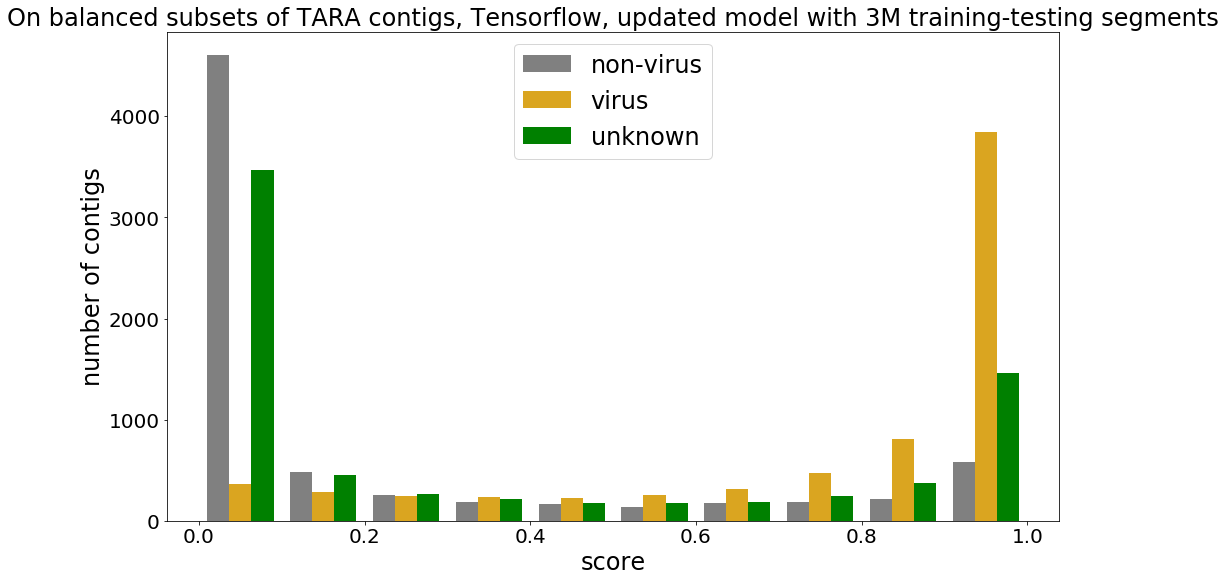

In [94]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.Prob_class_1_3M_train,df_virus.Prob_class_1_3M_train, df_unknown_subsample.Prob_class_1_3M_train ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus','virus','unknown'],color=['grey', 'goldenrod', 'green'])
ax0.set_title('On balanced subsets of TARA contigs, Tensorflow, updated model with 3M training-testing segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

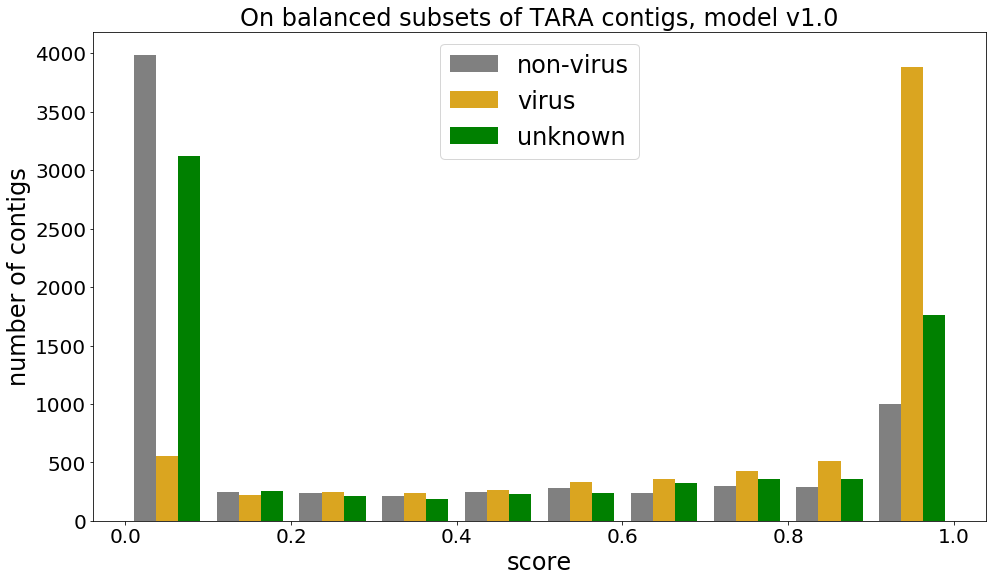

In [162]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.probability,df_virus.probability,
           df_unknown_subsample.probability]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus',
                                                  'virus',
                                                  'unknown'],
         color=['grey', 'goldenrod', 'green'])
ax0.set_title('On balanced subsets of TARA contigs, model v1.0',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

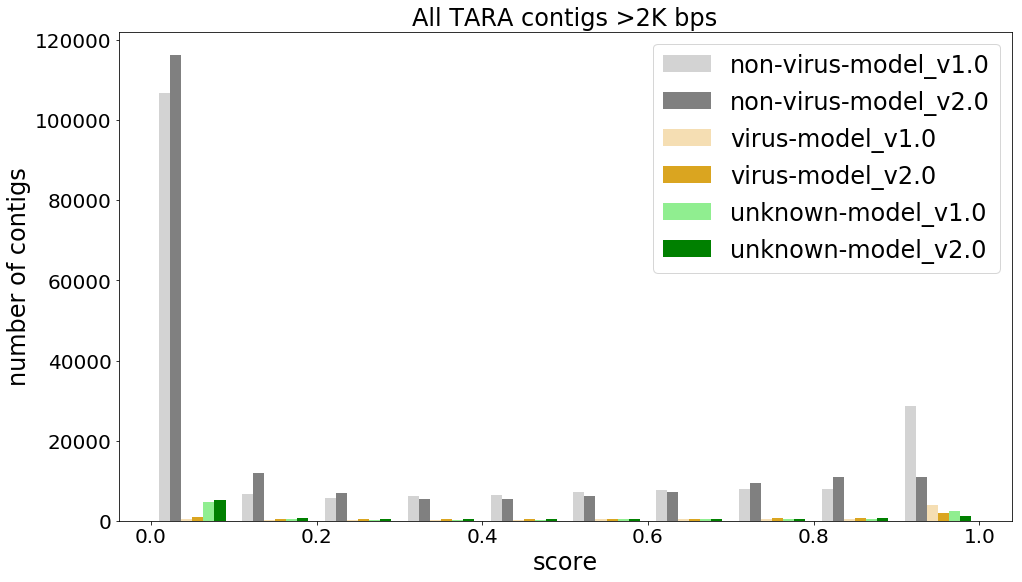

In [176]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus.probability,df_nonvirus.hybrid_probability,df_virus.probability,
           df_virus.hybrid_probability,df_unknown.probability,df_unknown.hybrid_probability ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus-model_v1.0','non-virus-model_v2.0',
                                                  'virus-model_v1.0','virus-model_v2.0',
                                                  'unknown-model_v1.0','unknown-model_v2.0'],
         color=['lightgrey','grey', 'wheat','goldenrod', 'lightgreen','green'])
ax0.set_title('All TARA contigs >2K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.legend(prop={'size': 24})

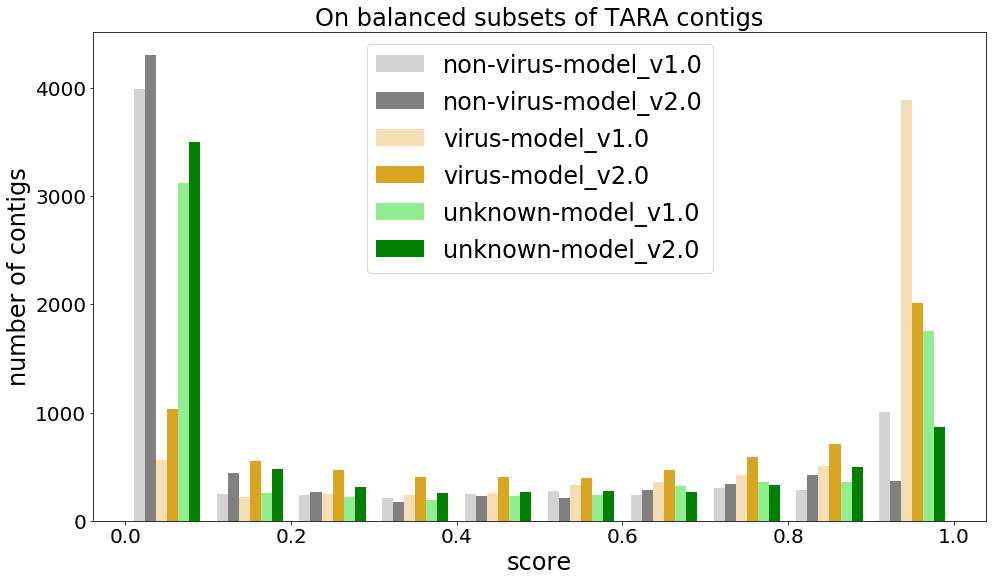

In [161]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.probability,df_nonvirus_subsample.hybrid_probability,df_virus.probability,
           df_virus.hybrid_probability,df_unknown_subsample.probability,df_unknown_subsample.hybrid_probability ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus-model_v1.0','non-virus-model_v2.0',
                                                  'virus-model_v1.0','virus-model_v2.0',
                                                  'unknown-model_v1.0','unknown-model_v2.0'],
         color=['lightgrey','grey', 'wheat','goldenrod', 'lightgreen','green'])
ax0.set_title('On balanced subsets of TARA contigs',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.legend(prop={'size': 24})

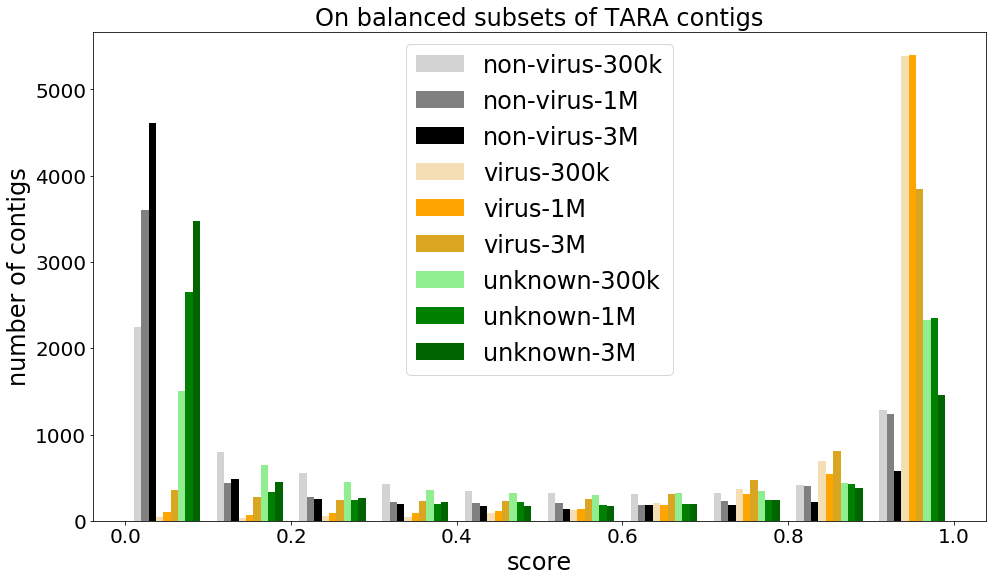

In [93]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.Prob_class_1_300k_full,df_nonvirus_subsample.Prob_class_1_1M_combined,df_nonvirus_subsample.Prob_class_1_3M_train,
           df_virus.Prob_class_1_300k_full,
           df_virus.Prob_class_1_1M_combined,df_virus.Prob_class_1_3M_train,
           df_unknown_subsample.Prob_class_1_300k_full,df_unknown_subsample.Prob_class_1_1M_combined,df_unknown_subsample.Prob_class_1_3M_train ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus-300k','non-virus-1M','non-virus-3M',
                                                  'virus-300k','virus-1M','virus-3M',
                                                  'unknown-300k','unknown-1M','unknown-3M'],
         color=['lightgrey','grey', 'black','wheat','orange','goldenrod',  'lightgreen','green','darkgreen'])
ax0.set_title('On balanced subsets of TARA contigs',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.legend(prop={'size': 24})

In [134]:
balaced_virus_nonvirus = pd.concat([df_virus,df_nonvirus_subsample])
balaced_matrix_virus_nonvirus_hybrid = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_prediction)
auprc_balaced_virus_nonvirus_hybrid = average_precision_score(balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_probability)
precision_balaced_virus_nonvirus_hybrid, recall_balaced_virus_nonvirus_hybrid, thresholds_balaced_virus_nonvirus_hybrid = precision_recall_curve(
    balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_probability)

balaced_matrix_virus_nonvirus_old = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.prediction)
auprc_balaced_virus_nonvirus_old = average_precision_score(balaced_virus_nonvirus.label, balaced_virus_nonvirus.probability)
precision_balaced_virus_nonvirus_old, recall_balaced_virus_nonvirus_old, thresholds_balaced_virus_nonvirus_old = precision_recall_curve(
    balaced_virus_nonvirus.label, balaced_virus_nonvirus.probability)


        

In [135]:
#balaced_matrix_virus_nonvirus_dl = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.Prob_class_1)
auprc_balaced_virus_nonvirus_dl = average_precision_score(balaced_virus_nonvirus[balaced_virus_nonvirus.Prob_class_1>0].label, balaced_virus_nonvirus[balaced_virus_nonvirus.Prob_class_1>0].Prob_class_1)
precision_balaced_virus_nonvirus_dl, recall_balaced_virus_nonvirus_dl, thresholds_balaced_virus_nonvirus_dl = precision_recall_curve(
    balaced_virus_nonvirus[balaced_virus_nonvirus.Prob_class_1>0].label, balaced_virus_nonvirus[balaced_virus_nonvirus.Prob_class_1>0].Prob_class_1)



In [56]:
balaced_virus_nonvirus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.0,0.013460,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.0,0.984607,True,186616,no rank,environmental samples,Virus,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.0,0.273456,False,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.0,0.972844,True,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.0,0.462958,False,439488,no rank,ssRNA viruses,Virus,True,False,with annotation


In [57]:
balaced_matrix_virus_nonvirus_hybrid

array([[5415, 1626],
       [2865, 4176]])

In [58]:
balaced_matrix_virus_nonvirus_old

array([[4931, 2110],
       [1534, 5507]])

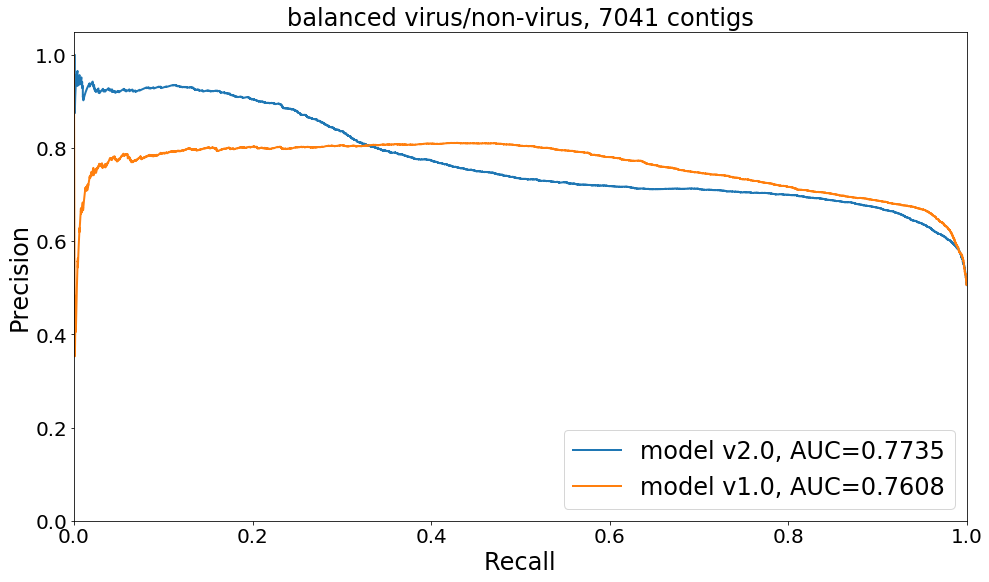

In [167]:
        lw = 2
        plt.figure(figsize=(16, 9), dpi=80)
        plt.clf()
        plt.plot(recall_balaced_virus_nonvirus_hybrid, precision_balaced_virus_nonvirus_hybrid, lw=lw, 
                 label='model v2.0, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_hybrid))
        plt.plot(recall_balaced_virus_nonvirus_old, precision_balaced_virus_nonvirus_old, lw=lw, 
                 label='model v1.0, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_old))
        plt.plot(recall_balaced_virus_nonvirus_dl, precision_balaced_virus_nonvirus_dl, lw=lw, 
                 label='model tensorflow, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_dl))
        plt.xlabel('Recall',fontsize=24)
        plt.ylabel('Precision',fontsize=24)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.tick_params(labelsize=20)
        plt.title('balanced virus/non-virus, 7041 contigs',fontsize=24)
        plt.legend(loc="lower right",fontsize=24)

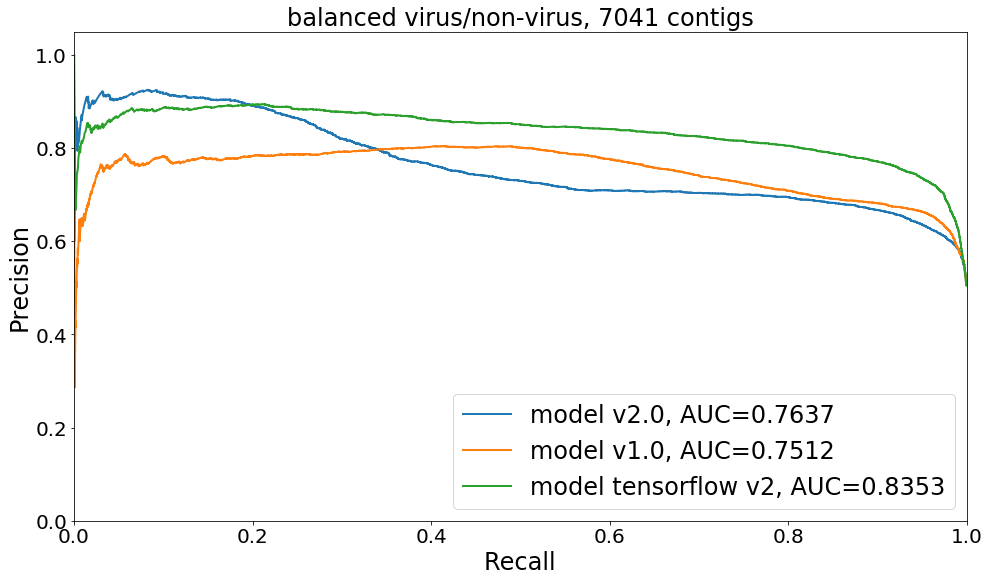

In [137]:
        lw = 2
        plt.figure(figsize=(16, 9), dpi=80)
        plt.clf()
        plt.plot(recall_balaced_virus_nonvirus_hybrid, precision_balaced_virus_nonvirus_hybrid, lw=lw, 
                 label='model v2.0, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_hybrid))
        plt.plot(recall_balaced_virus_nonvirus_old, precision_balaced_virus_nonvirus_old, lw=lw, 
                 label='model v1.0, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_old))
        plt.plot(recall_balaced_virus_nonvirus_dl, precision_balaced_virus_nonvirus_dl, lw=lw, 
                 label='model tensorflow v2, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_dl))
        plt.xlabel('Recall',fontsize=24)
        plt.ylabel('Precision',fontsize=24)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.tick_params(labelsize=20)
        plt.title('balanced virus/non-virus, 7041 contigs',fontsize=24)
        plt.legend(loc="lower right",fontsize=24)



#### using all TARA contigs - imbalanced

In [60]:
df_virus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.0,0.013460,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.0,0.984607,True,186616,no rank,environmental samples,Virus,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.0,0.273456,False,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.0,0.972844,True,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.0,0.462958,False,439488,no rank,ssRNA viruses,Virus,True,False,with annotation


In [61]:

imbalaced_virus_nonvirus = pd.concat([df_virus,df_nonvirus])
imbalaced_matrix_virus_nonvirus_hybrid = confusion_matrix(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_prediction)
auprc_imbalaced_virus_nonvirus_hybrid = average_precision_score(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_probability)
precision_imbalaced_virus_nonvirus_hybrid, recall_imbalaced_virus_nonvirus_hybrid, thresholds_imbalaced_virus_nonvirus_hybrid = precision_recall_curve(
    imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_probability)

imbalaced_matrix_virus_nonvirus_old = confusion_matrix(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.prediction)
auprc_imbalaced_virus_nonvirus_old = average_precision_score(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.probability)
precision_imbalaced_virus_nonvirus_old, recall_imbalaced_virus_nonvirus_old, thresholds_imbalaced_virus_nonvirus_old = precision_recall_curve(
    imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.probability)


        
    

In [62]:
imbalaced_virus_nonvirus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.0,0.013460,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.0,0.984607,True,186616,no rank,environmental samples,Virus,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.0,0.273456,False,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.0,0.972844,True,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.0,0.462958,False,439488,no rank,ssRNA viruses,Virus,True,False,with annotation


In [63]:
imbalaced_matrix_virus_nonvirus_hybrid

array([[146072,  44951],
       [  2865,   4176]])

In [64]:
imbalaced_matrix_virus_nonvirus_old

array([[131866,  59157],
       [  1534,   5507]])

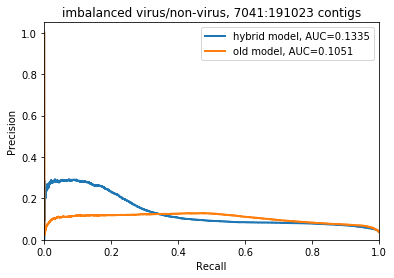

In [65]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_imbalaced_virus_nonvirus_hybrid, precision_imbalaced_virus_nonvirus_hybrid, lw=lw, 
                 label='hybrid model, AUC={0:0.4f}'.format(auprc_imbalaced_virus_nonvirus_hybrid))
        plt.plot(recall_imbalaced_virus_nonvirus_old, precision_imbalaced_virus_nonvirus_old, lw=lw, 
                 label='old model, AUC={0:0.4f}'.format(auprc_imbalaced_virus_nonvirus_old))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('imbalanced virus/non-virus, 7041:191023 contigs')
        plt.legend(loc="upper right")


### Check the performance of the Euk/non-euk model

In [66]:
imbalaced_euk_noneuk = pd.concat([df_euk,df_noneuk])

In [67]:
balaced_euk_noneuk = pd.concat([df_euk,df_noneuk_subsample])

In [68]:
matrix_euk_non_euk_imbalanced = confusion_matrix(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.pred_euk_non_euk)

In [69]:
matrix_euk_non_euk_imbalanced

array([[23114, 17806],
       [78591, 78232]])

In [70]:
matrix_euk_non_euk_balanced = confusion_matrix(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.pred_euk_non_euk)

In [71]:
matrix_euk_non_euk_balanced

array([[23114, 17806],
       [20394, 20526]])

In [72]:
auprc_euk_imbalanced = average_precision_score(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.score_euk_non_euk)

In [73]:
auprc_euk_balanced = average_precision_score(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.score_euk_non_euk)

In [74]:
auprc_euk_balanced

0.49113063826830622

In [75]:
auprc_euk_balanced

0.49113063826830622

In [76]:
precision_euk_imbalanced, recall_euk_imbalanced, thresholds_euk_imbalanced = precision_recall_curve(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.score_euk_non_euk)

In [77]:
precision_euk_balanced, recall_euk_balanced, thresholds_euk_balanced = precision_recall_curve(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.score_euk_non_euk)

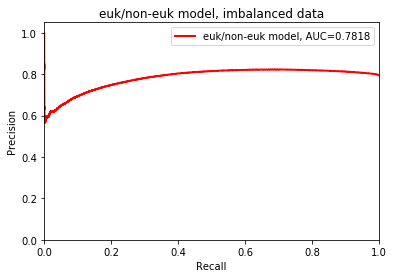

In [78]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_euk_imbalanced, precision_euk_imbalanced, lw=lw, color='red',
                 label='euk/non-euk model, AUC={0:0.4f}'.format(auprc_euk_imbalanced))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('euk/non-euk model, imbalanced data')
        plt.legend(loc="upper right")



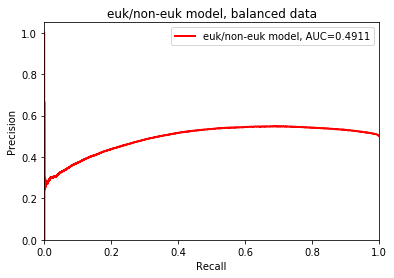

In [79]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_euk_balanced, precision_euk_balanced, lw=lw, color='red',
                 label='euk/non-euk model, AUC={0:0.4f}'.format(auprc_euk_balanced))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('euk/non-euk model, balanced data')
        plt.legend(loc="upper right")



#### Euk/non-Euk itself does not perform very well using the MEGA annotation as ground truth

#### it's still possible, the euk/non-euk works for some family......

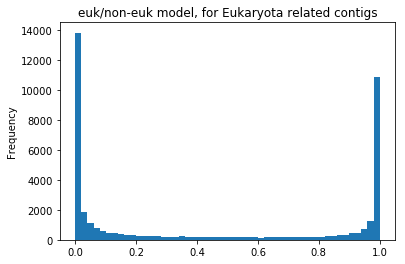

In [80]:
new_table[new_table.top_label=='Eukaryota'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Eukaryota related contigs')

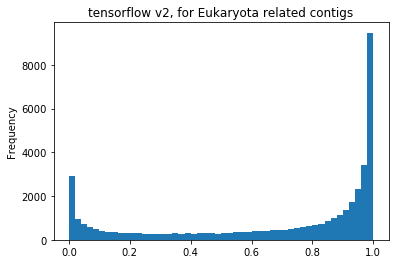

In [138]:
new_table2[new_table2.top_label=='Eukaryota'].Prob_class_1.plot.hist(bins=50, title='tensorflow v2, for Eukaryota related contigs')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


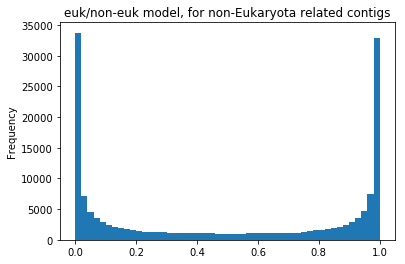

In [81]:
new_table[new_table.top_label!='Eukaryota'][new_table.annotation_label=='with annotation'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for non-Eukaryota related contigs')

#### This means removing low euk/non-euk score contigs, will not remove many real virus

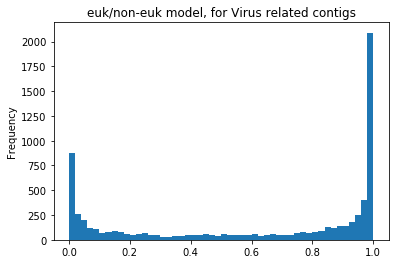

In [82]:
new_table[new_table.label==1].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Virus related contigs')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


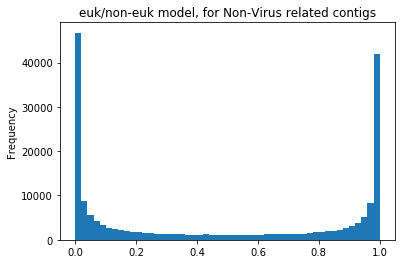

In [83]:
new_table[new_table.label==0][new_table.annotation_label=='with annotation'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Non-Virus related contigs')

In [84]:
len(new_table[new_table.probability>=0.9])

34939

In [85]:
len(new_table[new_table.probability>=0.9][new_table.label==1.0])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


3882

In [86]:
len(new_table[new_table.probability>=0.9][new_table.label==0.0])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


31057

In [87]:
len(new_table[new_table.probability<=0.1])

111998

In [88]:
len(new_table[new_table.probability<=0.1][new_table.label==1.0])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


558

In [89]:
len(new_table[new_table.probability<=0.1][new_table.label==0.0])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


111440

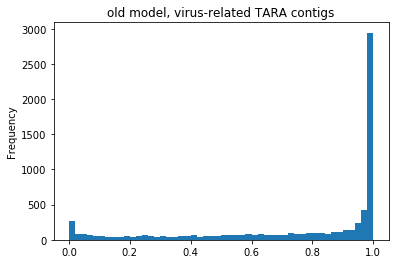

In [90]:
new_table[new_table.label==1.0].probability.plot.hist(bins=50, title = 'old model, virus-related TARA contigs')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


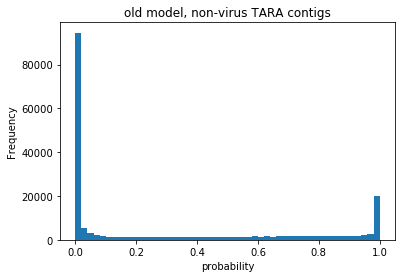

In [91]:
ax = new_table[new_table.label==0.0][new_table.annotation_label=='with annotation'].probability.plot.hist(bins=50, title = 'old model, non-virus TARA contigs')
ax.set_xlabel("probability")

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


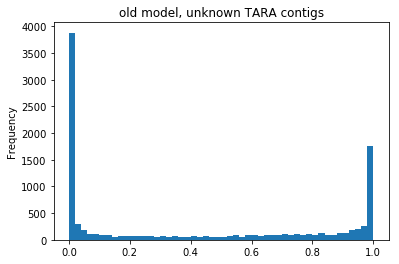

In [92]:
new_table[new_table.label==0.0][new_table.annotation_label!='with annotation'].probability.plot.hist(bins=50, title = 'old model, unknown TARA contigs')

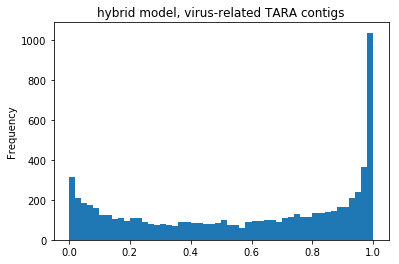

In [93]:
new_table[new_table.label==1.0].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, virus-related TARA contigs')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


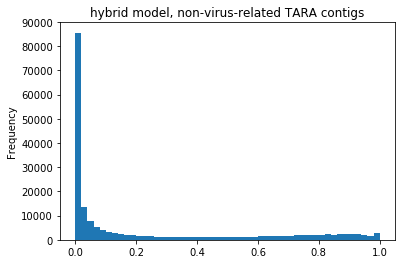

In [94]:
new_table[new_table.label==0.0][new_table.annotation_label=='with annotation'].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, non-virus-related TARA contigs')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


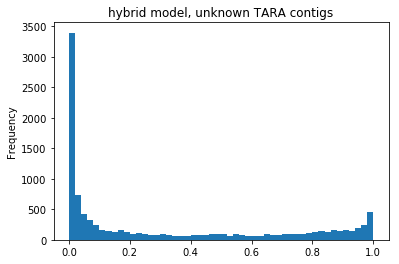

In [95]:
new_table[new_table.label==0.0][new_table.annotation_label!='with annotation'].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, unknown TARA contigs')

### Check the micromous -related contigs

#### most of micromonas contigs has lower euk/non-euk score, prone to be euk....

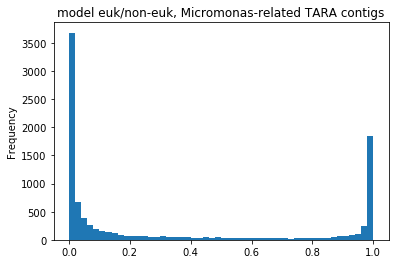

In [174]:
df_micromonus.score_euk_non_euk.plot.hist(bins=50, title = 'model euk/non-euk, Micromonas-related TARA contigs')

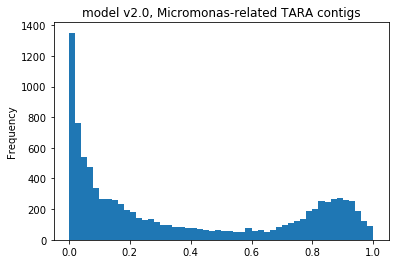

In [172]:
df_micromonus.hybrid_probability.plot.hist(bins=50, title = 'model v2.0, Micromonas-related TARA contigs')

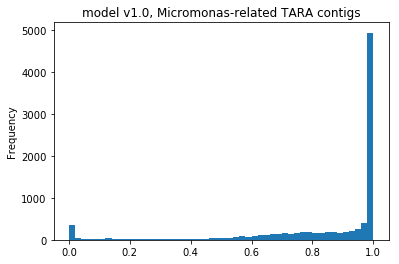

In [173]:
df_micromonus.probability.plot.hist(bins=50, title = 'model v1.0, Micromonas-related TARA contigs')

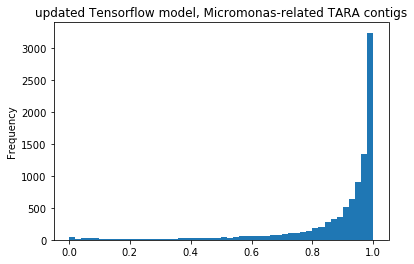

In [139]:
df_micromonus[df_micromonus.Prob_class_1>0].Prob_class_1.plot.hist(bins=50, title = 'updated Tensorflow model, Micromonas-related TARA contigs')

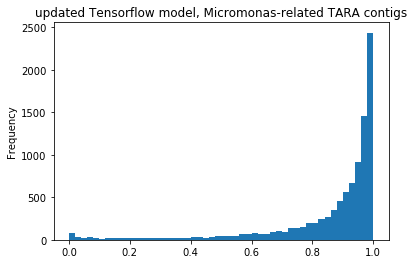

In [59]:
df_micromonus[df_micromonus.Prob_class_1>0].Prob_class_1.plot.hist(bins=50, title = 'updated Tensorflow model, Micromonas-related TARA contigs')

In [99]:
sub_table = new_table.loc[:,['probability','hybrid_probability','label','tax_id','rank','tax_name']]

In [100]:
sub_table.head()

,probability,hybrid_probability,label,tax_id,rank,tax_name
0,0.000375,0.000097,0.0,1236,class,Gammaproteobacteria
1,0.000088,0.000032,0.0,254161,species,Pseudomonas pachastrellae
2,0.000041,0.000019,0.0,254161,species,Pseudomonas pachastrellae
3,0.000056,0.000021,0.0,286,genus,Pseudomonas
4,0.000040,0.000018,0.0,286,genus,Pseudomonas


In [101]:
grouped = sub_table.groupby(['label'])

In [102]:
import pandas

In [103]:
grouped_category = new_table.groupby('category')

In [104]:
boxplot_data_old = [new_table[new_table.category=='virus'].probability,new_table[new_table.category=='nonvirus'].probability,
               new_table[new_table.category=='unknown'].probability]

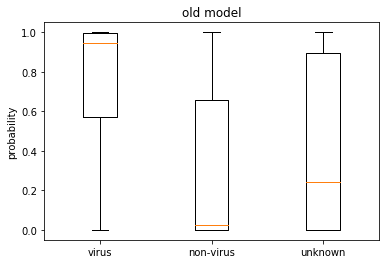

In [105]:
plt.figure()
label_list = ['virus','non-virus','unknown']
plt.boxplot(boxplot_data_old,labels = label_list)
plt.title('old model')
plt.ylabel('probability')
plt.show()

In [62]:
boxplot_data_hybrid = [new_table[new_table.category=='virus'].Prob_class_1,new_table2[new_table2.category=='nonvirus'].Prob_class_1,
               new_table2[new_table2.category=='unknown'].Prob_class_1]

AttributeError: 'DataFrame' object has no attribute 'category'

In [73]:
boxplot_data_dl = [new_table2[new_table2.category=='virus'].Prob_class_1.tolist(),new_table2[new_table2.category=='nonvirus'].Prob_class_1.tolist(),
               new_table2[new_table2.category=='unknown'].Prob_class_1.tolist()]

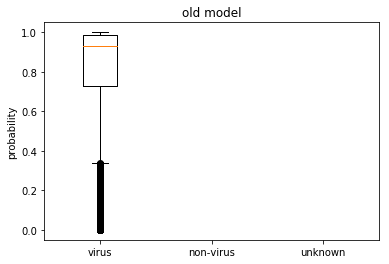

In [76]:
plt.figure()
label_list = ['virus','non-virus','unknown']
plt.boxplot(boxplot_data_dl,labels = label_list)
plt.title('old model')
plt.ylabel('probability')
plt.show()

In [74]:
boxplot_data_dl

[[0.043074,
  0.543357,
  0.337569,
  0.8616440000000001,
  0.212259,
  0.41721099999999994,
  0.9449709999999999,
  0.61768,
  0.134796,
  0.37799499999999997,
  0.37799499999999997,
  0.630272,
  0.630272,
  0.535882,
  0.535882,
  0.733777,
  0.733777,
  0.956108,
  0.5857100000000001,
  0.348962,
  0.42447700000000005,
  0.14014200000000002,
  0.0880436,
  0.487029,
  0.07698089999999999,
  0.7620520000000001,
  0.7620520000000001,
  0.956521,
  0.9560620000000001,
  0.998075,
  0.995505,
  0.612191,
  0.7542939999999999,
  0.59291,
  0.9692870000000001,
  0.9898950000000001,
  0.985505,
  0.689181,
  0.57845,
  0.983017,
  0.38594,
  0.8952969999999999,
  0.9917549999999999,
  0.973417,
  0.9732,
  0.9795530000000001,
  0.7421409999999999,
  0.997397,
  0.974649,
  0.559401,
  0.807665,
  0.9776020000000001,
  0.9591149999999999,
  0.588306,
  0.9727520000000001,
  0.959937,
  0.9816540000000001,
  0.9820909999999999,
  0.180067,
  0.96383,
  0.51163,
  0.504995,
  0.0533127,
  0.

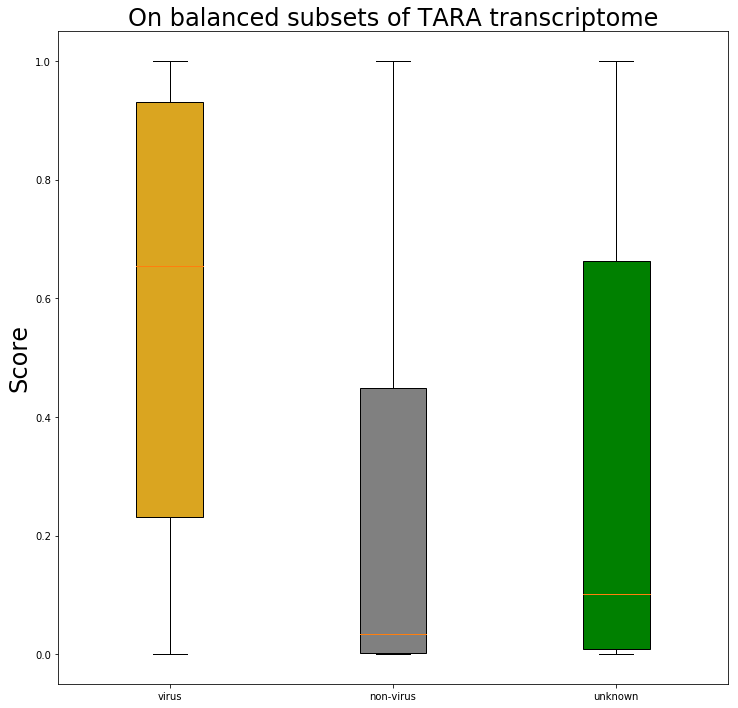

In [139]:
colors = ['goldenrod', 'grey', 'green']



fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

label_list = ['virus','non-virus','unknown']
bplot1 = ax0.boxplot(boxplot_data_hybrid,labels = label_list,patch_artist=True)
ax0.set_title('On balanced subsets of TARA transcriptome',fontsize=24)
ax0.set_ylabel('Score',fontsize=24)



for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

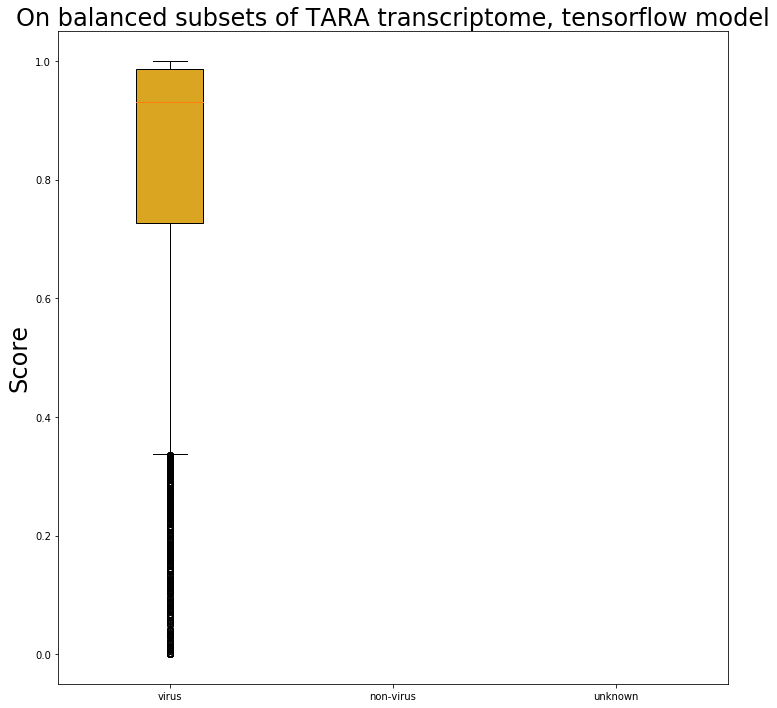

In [75]:
colors = ['goldenrod', 'grey', 'green']



fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

label_list = ['virus','non-virus','unknown']
bplot1 = ax0.boxplot(boxplot_data_dl,labels = label_list,patch_artist=True)
ax0.set_title('On balanced subsets of TARA transcriptome, tensorflow model',fontsize=24)
ax0.set_ylabel('Score',fontsize=24)



for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

In [108]:
predict_nonvirus = sub_table.groupby(['label']).get_group(0.0)

In [109]:
predict_nonvirus.head()

,probability,hybrid_probability,label,tax_id,rank,tax_name
0,0.000375,0.000097,0.0,1236,class,Gammaproteobacteria
1,0.000088,0.000032,0.0,254161,species,Pseudomonas pachastrellae
2,0.000041,0.000019,0.0,254161,species,Pseudomonas pachastrellae
3,0.000056,0.000021,0.0,286,genus,Pseudomonas
4,0.000040,0.000018,0.0,286,genus,Pseudomonas


In [110]:
predict_nonvirus[predict_nonvirus.probability>0.99].describe()

,probability,hybrid_probability,label,tax_id
count,19360.000000,19360.000000,19360.0,1.936000e+04
mean,0.998376,0.379285,0.0,3.044789e+05
std,0.002465,0.379769,0.0,4.887216e+05
min,0.990001,0.000009,0.0,-2.000000e+00
25%,0.997727,0.037893,0.0,5.653000e+03
50%,0.999668,0.205307,0.0,5.750600e+04
75%,0.999984,0.778857,0.0,2.965870e+05
max,1.000000,1.000000,0.0,1.904754e+06


In [111]:
grouped = predict_nonvirus.loc[:,['probability','hybrid_probability','rank']].groupby(['rank'])

In [112]:
predict_nonvirus_rank = predict_nonvirus.loc[:,['probability','hybrid_probability','rank']]

In [113]:
def convert_rank(rank):
    if rank == 'no rank':
        return 'no rank'
    else:
        return 'rank'
    

In [114]:
predict_nonvirus_rank['no_rank'] = predict_nonvirus_rank['rank'].map(convert_rank)

In [115]:
predict_nonvirus_rank.head()

,probability,hybrid_probability,rank,no_rank
0,0.000375,0.000097,class,rank
1,0.000088,0.000032,species,rank
2,0.000041,0.000019,species,rank
3,0.000056,0.000021,genus,rank
4,0.000040,0.000018,genus,rank


In [116]:
predict_nonvirus_rank_subset = predict_nonvirus_rank[(predict_nonvirus_rank['rank'] =='class') | (predict_nonvirus_rank['rank'] =='family') | (predict_nonvirus_rank['rank'] =='genus')\
                      | (predict_nonvirus_rank['rank'] =='kingdom')| (predict_nonvirus_rank['rank'] =='no rank')| (predict_nonvirus_rank['rank'] =='order')\
                      | (predict_nonvirus_rank['rank'] =='phylum')| (predict_nonvirus_rank['rank'] =='species')| (predict_nonvirus_rank['rank'] =='superkingdom')]


In [117]:
predict_nonvirus_rank_grouped = predict_nonvirus_rank.groupby(['no_rank'])

In [118]:
predict_nonvirus_rank_grouped.describe()

hybrid_probability                                              \
                     count      mean       std           min       25%   
no_rank                                                                  
no rank            35717.0  0.291535  0.360786  5.826176e-16  0.004860   
rank              165544.0  0.227086  0.320774  1.114855e-20  0.002081   

                                 probability                      \
              50%       75%  max       count      mean       std   
no_rank                                                            
no rank  0.059424  0.653988  1.0     35717.0  0.401543  0.414239   
rank     0.031430  0.420127  1.0    165544.0  0.287961  0.377806   

                                                          
                  min       25%       50%       75%  max  
no_rank                                                   
no rank  6.163252e-27  0.000631  0.232523  0.851715  1.0  
rank     1.608784e-40  0.000074  0.016476  0.611738  1.0

no rank         Axes(0.1,0.15;0.363636x0.75)
rank       Axes(0.536364,0.15;0.363636x0.75)
dtype: object

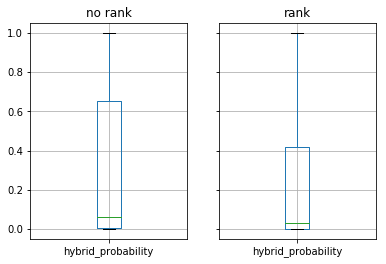

In [119]:
predict_nonvirus_rank_grouped.boxplot(column=['hybrid_probability'])

no rank         Axes(0.1,0.15;0.363636x0.75)
rank       Axes(0.536364,0.15;0.363636x0.75)
dtype: object

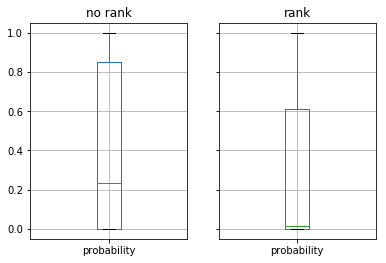

In [120]:
predict_nonvirus_rank_grouped.boxplot(column=['probability'])

In [121]:
9169.0/111440

0.08227745872218234

In [122]:
tax_name_count_99 = predict_nonvirus[predict_nonvirus.probability>0.99].groupby('tax_name').size().reset_index()

In [123]:
tax_name_count_99['percent_99'] = tax_name_count_99[0].apply(lambda x: 100*x/float(tax_name_count_99.sum()))

In [124]:
tax_name_count_99.head()

,tax_name,0,percent_99
0,-2,59,0.304752
1,Acanthamoeba castellanii str. Neff,4,0.020661
2,Acidimicrobiia,1,0.005165
3,Acidithiobacillales bacterium SG8_45,4,0.020661
4,Acinetobacter,8,0.041322


In [125]:
tax_name_count_01 = predict_nonvirus[predict_nonvirus.probability<0.01].groupby('tax_name').size().reset_index()

In [126]:
tax_name_count_01['percent_01'] = tax_name_count_01[0].apply(lambda x: 100*x/float(tax_name_count_01.sum()))

In [127]:
tax_name_count_01.head()


,tax_name,0,percent_01
0,-2,30,0.032458
1,Acanthamoeba castellanii,1,0.001082
2,Acidimicrobiia,1,0.001082
3,Acidobacteria,7,0.007574
4,Acinetobacter,920,0.995380


In [128]:
tax_name = pd.merge(tax_name_count_99,tax_name_count_01,how='inner',on=['tax_name'])

In [129]:
tax_name.head()

,tax_name,0_x,percent_99,0_y,percent_01
0,-2,59,0.304752,30,0.032458
1,Acidimicrobiia,1,0.005165,1,0.001082
2,Acinetobacter,8,0.041322,920,0.995380
3,Actiniaria,6,0.030992,1,0.001082
4,Actinobacteria,42,0.216942,178,0.192584


In [130]:
tax_name['increase'] = tax_name.apply(lambda x:x['percent_99']/x['percent_01'], axis=1)

In [131]:
tax_name.sort_values(by='increase')

,tax_name,0_x,percent_99,0_y,percent_01,increase
324,Rhodobacterales bacterium HTCC2255,2,0.010331,1225,1.325370,0.007794
322,Rhodobacteraceae bacterium SB2,1,0.005165,310,0.335400,0.015400
444,unclassified Methylophilales,1,0.005165,249,0.269402,0.019173
251,Oceanospirillales,2,0.010331,366,0.395988,0.026088
292,Porticoccaceae,1,0.005165,181,0.195830,0.026376
370,Synechococcales,2,0.010331,362,0.391660,0.026376
388,Verrucomicrobia,2,0.010331,345,0.373268,0.027676
323,Rhodobacterales,4,0.020661,659,0.712995,0.028978
81,Candidatus Thioglobus singularis,7,0.036157,1100,1.190128,0.030381
330,SAR116 cluster,1,0.005165,145,0.156881,0.032925


In [132]:
tax_name.sort_values(by='percent_99')

,tax_name,0_x,percent_99,0_y,percent_01,increase
91,Chlorophyceae,1,0.005165,1,0.001082,4.774122
362,Spongiibacter,1,0.005165,53,0.057343,0.090078
120,Cycloclasticus,1,0.005165,23,0.024885,0.207571
221,Microbacteriaceae bacterium BACL25 MAG-120322-...,1,0.005165,12,0.012983,0.397843
115,Cryomorphaceae bacterium BACL22 MAG-120619-bin32,1,0.005165,20,0.021639,0.238706
465,uncultured marine microorganism HF4000_ANIW141I9,1,0.005165,2,0.002164,2.387061
104,Colwellia,1,0.005165,7,0.007574,0.682017
236,Nitrosopumilales,1,0.005165,4,0.004328,1.193530
349,Schizophora,1,0.005165,13,0.014065,0.367240
96,Chromatiales bacterium (ex Bugula neritina AB1),1,0.005165,27,0.029212,0.176819


In [133]:
1587.0/31057

0.05109959107447597

In [134]:
predict_nonvirus[predict_nonvirus.probability>0.9].groupby('tax_id').size()

tax_id
-2           128
 1          1744
 2          1587
 22           15
 29           16
 85            6
 126          11
 137           1
 146           2
 226         731
 237          12
 286         178
 287           5
 316          13
 356          43
 444           4
 469          17
 506           1
 520           6
 531           5
 543           5
 562          14
 641           9
 657          15
 662          20
 766           6
 838          11
 933           4
 958           8
 963          12
            ... 
 1783270      39
 1783272      52
 1783276       6
 1794811      37
 1797909       9
 1798416       7
 1798559       4
 1802260       7
 1802339       1
 1802371      18
 1805240       9
 1812810       9
 1813033       3
 1817868      27
 1822214       3
 1822215       3
 1822250     124
 1822263       7
 1853229       5
 1853230      13
 1853232       2
 1855377      17
 1856405      16
 1868282       1
 1873462      16
 1890424       8
 1890450       9
 189119

In [135]:
predict_nonvirus[predict_nonvirus.probability>0.9].groupby('rank').size()

rank
-2                   128
class               1224
family              2846
genus               4805
infraclass            31
infraorder             1
kingdom              330
no rank             7837
order               1775
phylum              1642
species             7654
species group         13
species subgroup       1
subclass              49
subfamily              4
subkingdom             5
suborder              20
subphylum             47
superclass             2
superkingdom        2624
superorder            19
dtype: int64

In [136]:
predict_nonvirus[predict_nonvirus.probability<0.1].groupby('rank').size()

rank
-2                     45
171193                  4
class               16530
family              11575
genus               16066
infraclass              9
infraorder              1
kingdom               280
no rank             16472
order                7921
phylum               9990
species             19646
species group          94
species subgroup        2
subclass               44
subfamily             109
subkingdom              1
suborder                5
subphylum              50
subspecies             10
superclass              1
superfamily             1
superkingdom        12575
superorder              9
dtype: int64

In [137]:
predict_virus = sub_table.groupby(['label']).get_group(1.0)

In [138]:
result = pd.read_csv('/Users/qingpeng/shred.fa.score',sep=' ',header=None,names=['probability','prediction'])

IOError: File /Users/qingpeng/shred.fa.score does not exist

In [ ]:
result

In [ ]:
result.probability.plot.hist(bins=100)